In [12]:
# Set the bucket name and a directory prefix where we're going to store our files
bucket = '<s3-bucket-name-here>'
prefix = 'sagemaker/DEMO-xgboost-dm'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [2]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For managing tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference

In [3]:
!wget https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
!apt-get install unzip -y
!unzip -o bank-additional.zip

--2020-08-18 08:13:36--  https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Resolving sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)... 52.218.221.137
Connecting to sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)|52.218.221.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432828 (423K) [application/zip]
Saving to: ‘bank-additional.zip.3’

bank-additional.zip 100%[===================>] 422.68K   828KB/s    in 0.5s    

2020-08-18 08:13:37 (828 KB/s) - ‘bank-additional.zip.3’ saved [432828/432828]

/bin/sh: apt-get: command not found
Archive:  bank-additional.zip
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: bank-additional/bank-additional-full.csv  


In [4]:
data = pd.read_csv('./bank-additional/bank-additional-full.csv')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
data

age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campaign  pdays  previous  \
0      telephone   may         mon       261         1    999         0   
1      telephone   may         mon       149         1    999         0   
2      telephone   may         mon       226         1    999         0   
3      telephone   may         mon       151         1    999         0   
4      telephone   may         mon       307         1    999         0   
...          ...   ...         ...       ...       ...    ...       ...   
41183   cellular   nov         fri       334         1    999         0   
41184   cellular   nov         fri       383         1    999         0   
41185   cellular   nov         fri       189         2    999         0   
41186   cellular   nov         fri       442         1    999         0   
41187   cellular   nov         fri       239         3    999         1   

          poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0      nonexistent           1.1          93.994          -36.4      4.857   
1      nonexistent           1.1          93.994          -36.4      4.857   
2      nonexistent           1.1          93.994          -36.4      4.857   
3      nonexistent           1.1          93.994          -36.4      4.857   
4      nonexistent           1.1          93.994          -36.4      4.857   
...            ...           ...             ...            ...        ...   
41183  nonexistent          -1.1          94.767          -50.8      1.028   
41184  nonexistent          -1.1          94.767          -50.8      1.028   
41185  nonexistent          -1.1          94.767          -50.8      1.028   
41186  nonexistent          -1.1          94.767          -50.8      1.028   
41187      failure          -1.1          94.767          -50.8      1.028   

       nr.employed    y  
0           5191.0   no  
1           5191.0   no  
2           5191.0   no  
3           5191.0   no  
4           5191.0   no  
...            ...  ...  
41183       4963.6  yes  
41184       4963.6   no  
41185       4963.6   no  
41186       4963.6  yes  
41187       4963.6   no  

[41188 rows x 21 columns]

col_0          % observations
job                          
admin.               0.253035
blue-collar          0.224677
entrepreneur         0.035350
housemaid            0.025736
management           0.070992
retired              0.041760
self-employed        0.034500
services             0.096363
student              0.021244
technician           0.163713
unemployed           0.024619
unknown              0.008012

col_0     % observations
marital                 
divorced        0.111974
married         0.605225
single          0.280859
unknown         0.001942

col_0                % observations
education                          
basic.4y                   0.101389
basic.6y                   0.055647
basic.9y                   0.146766
high.school                0.231014
illiterate                 0.000437
professional.course        0.127294
university.degree          0.295426
unknown                    0.042027

col_0    % observations
default                
no             0.791201
unknown        0.208726
yes            0.000073

col_0    % observations
housing                
no             0.452122
unknown        0.024036
yes            0.523842

col_0    % observations
loan                   
no             0.824269
unknown        0.024036
yes            0.151695

col_0      % observations
contact                  
cellular         0.634748
telephone        0.365252

col_0  % observations
month                
apr          0.063902
aug          0.149995
dec          0.004419
jul          0.174177
jun          0.129115
mar          0.013256
may          0.334296
nov          0.099568
oct          0.017432
sep          0.013839

col_0        % observations
day_of_week                
fri                0.190031
mon                0.206711
thu                0.209357
tue                0.196416
wed                0.197485

col_0        % observations
poutcome                   
failure            0.103234
nonexistent        0.863431
success            0.033335

col_0  % observations
y                    
no           0.887346
yes          0.112654

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

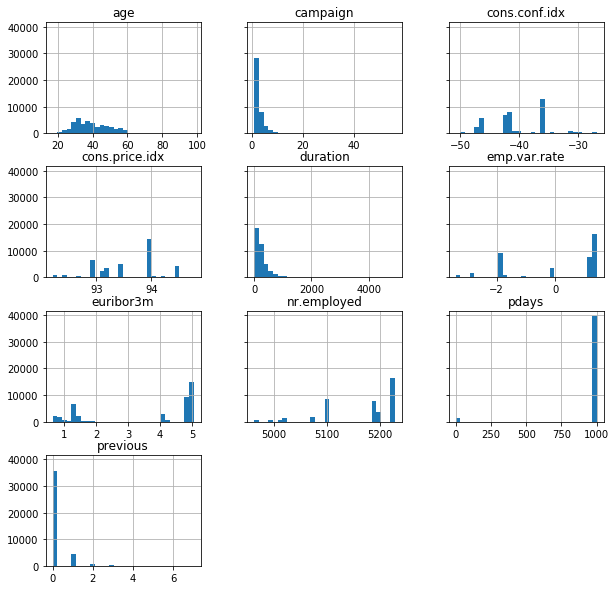

In [5]:
# Frequency tables for each categorical feature - how frequently does each feature value appear
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

y                    no       yes
job                              
admin.         0.248167  0.291379
blue-collar    0.235745  0.137500
entrepreneur   0.036445  0.026724
housemaid      0.026103  0.022845
management     0.071030  0.070690
retired        0.035187  0.093534
self-employed  0.034804  0.032112
services       0.099759  0.069612
student        0.016417  0.059267
technician     0.164523  0.157328
unemployed     0.023804  0.031034
unknown        0.008017  0.007974

y               no       yes
marital                     
divorced  0.113166  0.102586
married   0.612783  0.545690
single    0.272190  0.349138
unknown   0.001861  0.002586

y                          no       yes
education                              
basic.4y             0.102550  0.092241
basic.6y             0.057568  0.040517
basic.9y             0.152457  0.101940
high.school          0.232133  0.222198
illiterate           0.000383  0.000862
professional.course  0.127175  0.128233
university.degree    0.287239  0.359914
unknown              0.040495  0.054095

y              no       yes
default                    
no       0.776814  0.904526
unknown  0.223104  0.095474
yes      0.000082  0.000000

y              no       yes
housing                    
no       0.454088  0.436638
unknown  0.024160  0.023060
yes      0.521752  0.540302

y              no       yes
loan                       
no       0.823574  0.829741
unknown  0.024160  0.023060
yes      0.152266  0.147198

y               no       yes
contact                     
cellular   0.60991  0.830388
telephone  0.39009  0.169612

y            no       yes
month                    
apr    0.057267  0.116164
aug    0.151116  0.141164
dec    0.002545  0.019181
jul    0.178532  0.139871
jun    0.130212  0.120474
mar    0.007388  0.059483
may    0.352495  0.190948
nov    0.100826  0.089655
oct    0.011027  0.067888
sep    0.008591  0.055172

y                  no       yes
day_of_week                    
fri          0.191009  0.182328
mon          0.209779  0.182543
thu          0.207344  0.225216
tue          0.195277  0.205388
wed          0.196591  0.204526

y                  no       yes
poutcome                       
failure      0.099787  0.130388
nonexistent  0.887107  0.676940
success      0.013106  0.192672

age


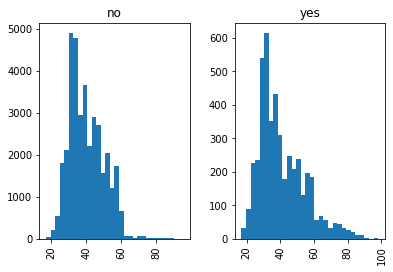

duration


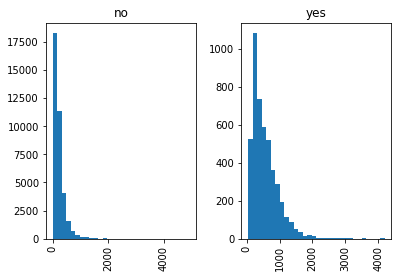

campaign


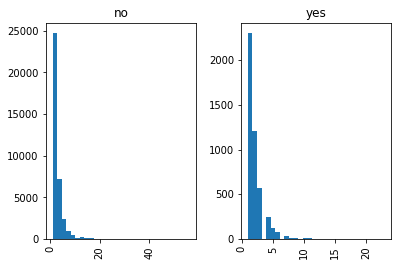

pdays


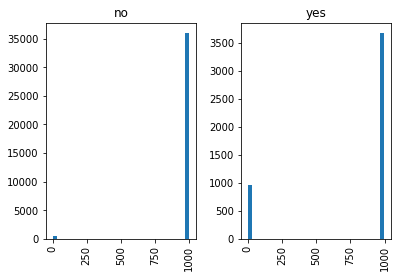

previous


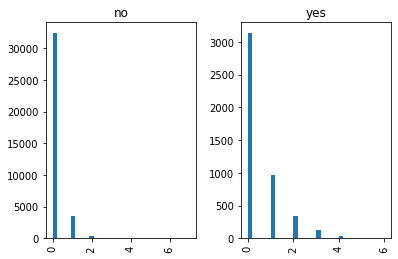

emp.var.rate


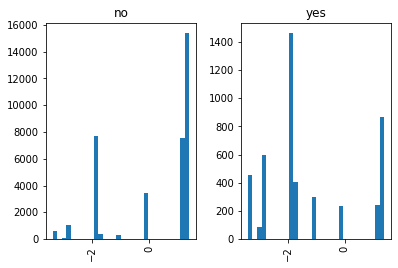

cons.price.idx


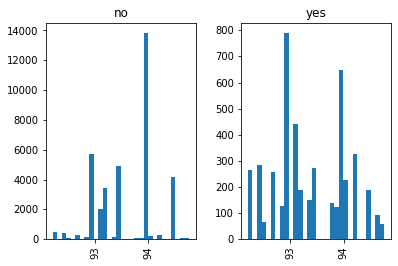

cons.conf.idx


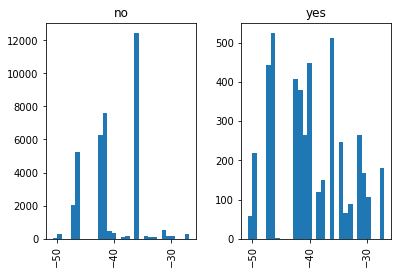

euribor3m


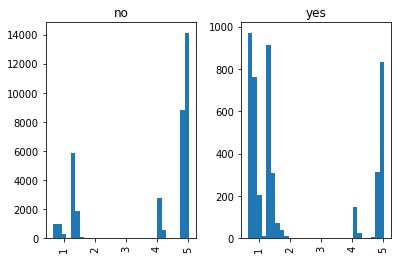

nr.employed


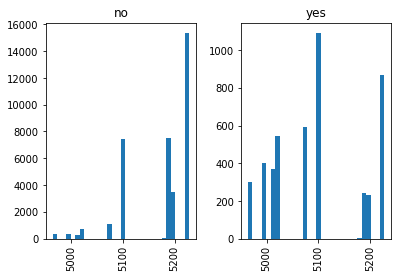

In [6]:
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))

for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=30)
    plt.show()

age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968        0.005312      -0.008173  -0.032897   
campaign            0.150754        0.127836      -0.013733   0.135133   
pdays               0.271004        0.078889      -0.091342   0.296899   
previous           -0.420489       -0.203130      -0.050936  -0.454494   
emp.var.rate        1.000000        0.775334       0.196041   0.972245   
cons.price.idx      0.775334        1.000000       0.058986   0.688230   
cons.conf.idx       0.196041        0.058986       1.000000   0.277686   
euribor3m           0.972245        0.688230       0.277686   1.000000   
nr.employed         0.906970        0.522034       0.100513   0.945154   

                nr.employed  
age               -0.017725  
duration          -0.044703  
campaign           0.144095  
pdays              0.372605  
previous          -0.501333  
emp.var.rate       0.906970  
cons.price.idx     0.522034  
cons.conf.idx      0.100513  
euribor3m          0.945154  
nr.employed        1.000000

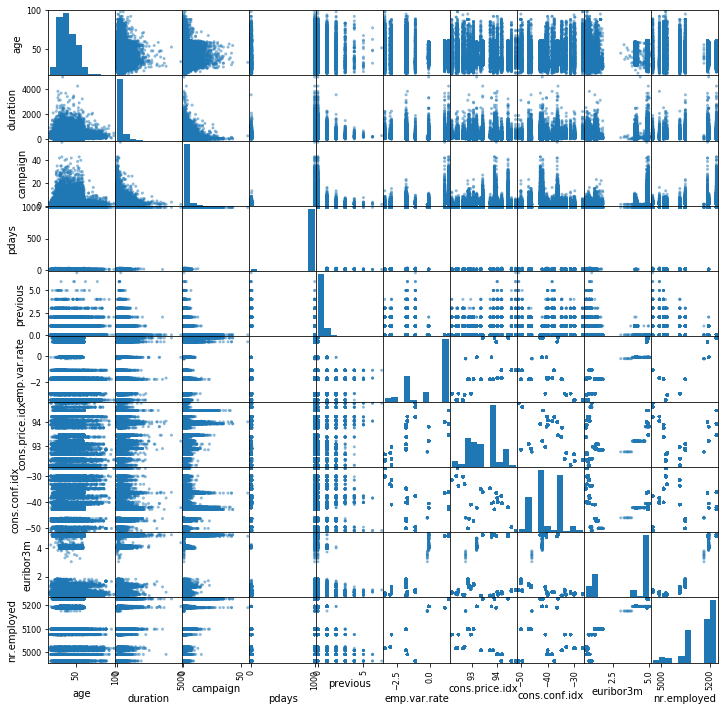

In [7]:
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

In [13]:
# If pdays is 999, simply state "no_previous_contact"
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)
# Replace student, retired and unemployed with "not_working" to group those featuress together
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)
# Convert categorical variables to sets of indicators
model_data = pd.get_dummies(data)
# Eliminate useless features
model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

In [14]:
# Randomly sort the data then split out first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])

In [15]:
# Prep the training set for the XGBoost algorithm - the target variable must be the first column and store the dataset as a CSV
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
# Same as above for the validation set
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

In [16]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [17]:
# pull the XGBoost image from ECR
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [18]:
# specify the inputs for our model - the training set and the validation set
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [19]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-18 08:19:52 Starting - Starting the training job...
2020-08-18 08:19:54 Starting - Launching requested ML instances......
2020-08-18 08:21:19 Starting - Preparing the instances for training......
2020-08-18 08:22:13 Downloading - Downloading input data...
2020-08-18 08:22:44 Training - Downloading the training image...
2020-08-18 08:23:16 Uploading - Uploading generated training model
2020-08-18 08:23:16 Completed - Training job completed
Arguments: train
[2020-08-18:08:23:05:INFO] Running standalone xgboost training.
[2020-08-18:08:23:05:INFO] File size need to be processed in the node: 4.35mb. Available memory size in the node: 8501.67mb
[2020-08-18:08:23:05:INFO] Determined delimiter of CSV input is ','
[08:23:05] S3DistributionType set as FullyReplicated
[08:23:05] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-08-18:08:23:05:INFO] Determined delimiter of CSV input is ','
[08:23:05] S3DistributionType se

In [20]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [21]:
# In order to make a request - serialize it as a CSV string and then decode the resulting CSV.
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

In [22]:
# Get our predictions
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy())

In [23]:
# Create a confusion matrix to compare the predicted values to the real values.
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions   0.0  1.0
actuals               
0            3594   42
1             389   94

In [24]:
# cleanup
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)